In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope

In [2]:
ass_data = pd.read_csv('../../cleanData/assessor_clean.csv', parse_dates=['CurrentSalesDate'])

/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Preliminary Cleaning

This data is very messy, and needs some work right off the bat.  For starters, many rows have 0 or null values for key columns we want to draw conclusions on.  Some of these make sense, for instance empty lots will have a property area and assessed improvement value of 0.  Others, like a lot area of 0 seem to indicate some error in reporting.

Next, there are a number of properties where PropertyArea > LotArea * NumberofStories, which should be impossible.

Finally, a couple *huge* lots in the millions of square feet are excluded from analysis since they dwarf all others by orders of magnitude

In [3]:
ass_data = ass_data.query('PropertyArea > 0 and LotArea > 0 and NumberofStories > 0')

# about 4 thousand properties are listed as having more square feet than is possible, not sure why
ass_data = ass_data.query('PropertyArea <= LotArea * NumberofStories')

ass_data = ass_data.query('LotArea < 300000')

Let's also fix the import issue with the type:

In [4]:
print(ass_data.keys()[26])

ExemptionCode


In [5]:
ass_data["ExemptionCode"].value_counts()

11.0    42323
11      24267
11.0      566
03        286
3.0       260
6.0        92
06         47
7.0        43
08         34
3.0        28
07         20
8.0         8
no          7
02          6
2.0         4
6.0         4
14          3
14.0        2
13.0        1
25          1
st          1
Name: ExemptionCode, dtype: int64

It looks like it's trying to be an integer, but there are some strange inputs, primarily `no` and `st`

In [6]:
ass_data.loc[ass_data["ExemptionCode"].isin(["no", "st"])]

,ClosedRollYear,PropertyLocation,ParcelNumber,Block,Lot,VolumeNumber,UseCode,UseDefinition,PropertyClassCode,PropertyClassCodeDefinition,...,SupervisorDistrict,AnalysisNeighborhood,the_geom,RowID,SalesYear,SalesMonth,SalesDay,Location,X,Y
30446,2017.0,1407 1405 sutter st0000,0689017,0689,017,5,comr,commercial retail,c,commercial stores,...,2,western addition,point (-122.423657052326 37.787018033115),20170689017,NaN,NaN,NaN,-122.423657052326 37.787018033115,-122.423657,37.787018
37115,2017.0,0000 2420 sutter st0000,1052023,1052,023,8,comm,commercial misc,g,garages (commercial),...,2,pacific heights,point (-122.440590145012 37.78544313124),20171052023,2011.0,8.0,9.0,-122.440590145012 37.78544313124,-122.440590,37.785443
45987,2017.0,0000 0330 cherry st0000,1013053,1013,053,7,sres,single family residential,d,dwelling,...,2,presidio heights,point (-122.456651700365 37.787368033595),20171013053,2005.0,7.0,1.0,-122.456651700365 37.787368033595,-122.456652,37.787368
99252,2017.0,0000 4552 19th st0000,2700013,2700,013,19,sres,single family residential,d,dwelling,...,8,castro/upper market,point (-122.440185574417 37.759223753154004),20172700013,2009.0,3.0,20.0,-122.440185574417 37.759223753154004,-122.440186,37.759224
111595,2017.0,0000 0085 saint elmo wy0000,3049032,3049,032,21,sres,single family residential,d,dwelling,...,7,west of twin peaks,point (-122.459355032326 37.731522032327),20173049032,1997.0,1.0,15.0,-122.459355032326 37.731522032327,-122.459355,37.731522
116257,2017.0,0000 0165 san fernando wy0000,3100014,3100,014,22,sres,single family residential,d,dwelling,...,7,west of twin peaks,point (-122.469335956616 37.733702035327),20173100014,1991.0,5.0,31.0,-122.469335956616 37.733702035327,-122.469336,37.733702
181278,2017.0,0000 0031 howth st0000,6948012a,6948,012a,41,sres,single family residential,d,dwelling,...,7,oceanview/merced/ingleside,point (-122.449558769828 37.72237104738),20176948012a,2003.0,6.0,12.0,-122.449558769828 37.72237104738,-122.449559,37.722371
193346,2017.0,0000 0045 howth st0000,6948012c,6948,012c,41,sres,single family residential,d,dwelling,...,7,oceanview/merced/ingleside,point (-122.449647123483 37.722311512111),20176948012c,2010.0,11.0,9.0,-122.449647123483 37.722311512111,-122.449647,37.722312


Hm, it looks just like a writing error. As we don't know what they should be, and taking into account that they make up a grand total of `8` data points, we can safely remove them.

In [7]:
ass_data = ass_data.query('ExemptionCode != "no" and ExemptionCode != "st"')
ass_data["ExemptionCode"].value_counts()

11.0    42323
11      24267
11.0      566
03        286
3.0       260
6.0        92
06         47
7.0        43
08         34
3.0        28
07         20
8.0         8
02          6
2.0         4
6.0         4
14          3
14.0        2
13.0        1
25          1
Name: ExemptionCode, dtype: int64

In [8]:
ass_data["ExemptionCode"] = ass_data["ExemptionCode"]\
    .apply(lambda x: (str(x) != "nan") and int(str(x)[:str(x).find(".")]) or x)
ass_data["ExemptionCode"].describe()

count     67995
unique       14
top          11
freq      42889
Name: ExemptionCode, dtype: int64

In [9]:
ass_data.dtypes

ClosedRollYear                          float64
PropertyLocation                         object
ParcelNumber                             object
Block                                    object
Lot                                      object
VolumeNumber                              int64
UseCode                                  object
UseDefinition                            object
PropertyClassCode                        object
PropertyClassCodeDefinition              object
YearPropertyBuilt                       float64
NumberofBathrooms                       float64
NumberofBedrooms                          int64
NumberofRooms                             int64
NumberofStories                           int64
NumberofUnits                             int64
ZoningCode                               object
ConstructionType                         object
LotDepth                                float64
LotFrontage                             float64
PropertyArea                            

The following pulled from [the dataset's source](https://sfassessor.org/news-information/property-data-0)

|Key                                     |Desc|
|:---------------------------------------|:---|
|Property Location                       |Situs/Location, as well as room/unit number|
|Neighborhood Code                       |ASR neighborhood code based on MLS districts|
|Block and Lot Number                    |Block and Lot Number (Full APN)|
|Volume Number                           |Volume number|
|Property Class Code                     |Property type|
|Year Property Built                     |Year improvement was built (can be blend of original and newer constructon)|
|Number of Bathrooms                     |Number of bathrooms (BA with no shower or tub is 1/2 bathroom)|
|Number of Bedrooms                      |Number of bedrooms (bedrooms have a closet)|
|Number of Rooms                         |Number of rooms, excluding bathrooms, halls, closets, etc.|
|Number of Stories                       |Number of stories|
|Number of Units                         |Number of units|
|Zoning Code                             |Zone code|
|Construction Type                       |Generally type of construction|
|Lot Depth                               |Depth of lot in linear feet|
|Lot Frontage                            |Linear footage of front facing side of lot (front foot)|
|Property Area in Square Feet            |Same as lot area|
|Basement Area                           |Square footage of basement|
|Lot Area                                |Square footage of lot|
|Lot Code                                |lot shapes, could be Rectangle, Square or Other|
|Prior Sales Date (YYMMDD)               |prior sale date|
|Tax Rate Area Code                      |Tax rate dependent on location within the City|
|Percent of Ownership                    |Percent of ownership|
|Closed Roll Exemption Type Code         |Exemption Code (see below for descriptions)|
|Closed Roll Status Code                 |i.e. Taxable, Non-Taxable, SBE, etc.|
|Closed Roll Misc. Exemption Value       |ExemptiSameons such as welfare|
|Closed Roll Homeowner Exemption Value   |Homeowner's exemption|
|Closed Roll Year                        |Roll YeSameSamear|
|Current Sales Date (YYMMDD)             |current sale date|
|Closed Roll Assessed Fixtures Value     |Assessed value of fixtures|
|Closed Roll Assessed Improvement Value  |Assessed value of improvements|
|Closed Roll Assessed Land Value         |Assessed value of land|
|Closed Roll Assessed Personal Prop Value|Assessed value of personal property|

In [10]:
ass_data["AssessedTotalValue"] = ass_data["AssessedFixturesValue"] + ass_data["AssessedImprovementValue"]\
    + ass_data["AssessedLandValue"] + ass_data["AssessedPersonalPropertyValue"]
ass_data[["AssessedFixturesValue", "AssessedImprovementValue", "AssessedLandValue", "AssessedPersonalPropertyValue",
          "AssessedTotalValue"]].head()

,AssessedFixturesValue,AssessedImprovementValue,AssessedLandValue,AssessedPersonalPropertyValue,AssessedTotalValue
3,0,45762,21280,0,67042
39,5505802,15801016,23701526,41847,45050191
75,95561,1664372,2219163,126375,4105471
80,0,459249,1009361,0,1468610
81,0,439111,989569,0,1428680


# Data Exploration

As we would expect, a definite positive correlation exists between property area and property value.  Some anomalies can already be picked out by eye from this graph

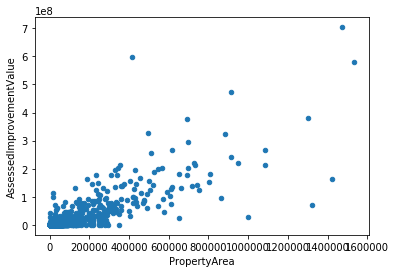

In [11]:
ass_data.plot.scatter(x='PropertyArea', y='AssessedImprovementValue')

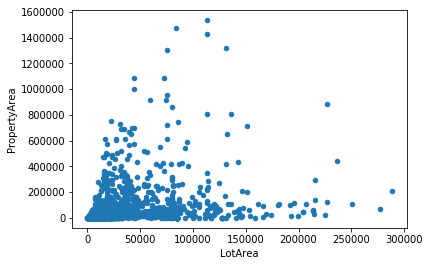

In [12]:
ass_data.plot.scatter(x='LotArea', y='PropertyArea')

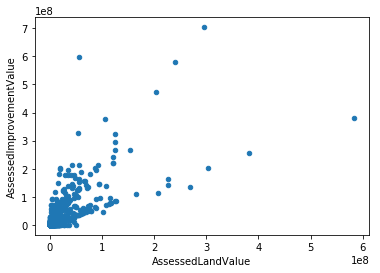

In [13]:
ass_data.plot.scatter(x='AssessedLandValue', y='AssessedImprovementValue')

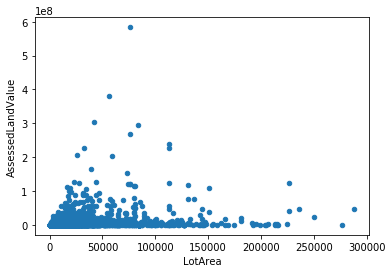

In [14]:
ass_data.plot.scatter(x='LotArea', y='AssessedLandValue')

Initial attempts at anomaly detection seem to identify "mansion" and "non-mansion" categories, which isn't too helpfull...

Feature engineering with value / sqare foot might help us out here

In [15]:
model = EllipticEnvelope()
labels = model.fit_predict(ass_data[['PropertyArea', 'AssessedTotalValue']])

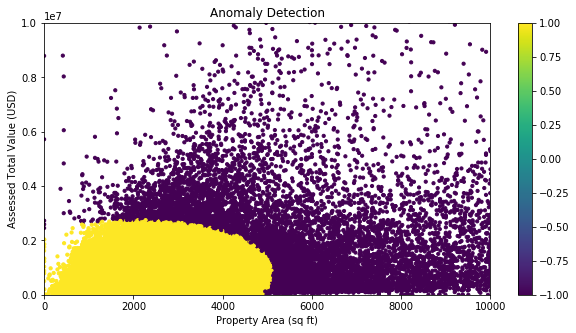

In [19]:
plt.figure(figsize=(10, 5))
scatter = plt.scatter(ass_data['PropertyArea'], ass_data['AssessedTotalValue'], c=labels, s=10)
plt.title('Anomaly Detection')
plt.xlabel('Property Area (sq ft)')
plt.ylabel('Assessed Total Value (USD)')

plt.xlim([0, 10000])
plt.ylim([0, 10000000])

plt.colorbar(scatter)
plt.show()